In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display, HTML
 
import calendar
import datetime as dt

import re

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
import pandas as pd
def data_loading(path):
    """
    This function reads the Excel data file from UCI Machinelearning repository 
    The data is stored into a pandas dataframe that the fuction returns  
    """
    df = pd.read_excel(path)
    return df

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = data_loading(data_url)

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
import calendar
def data_cleaning_and_prep(df):
    """
    This is the Data cleaning and PReparation Functio. It takes in a dataframe, does the data cleaning and prep and returns dataframe
    """
    ######*****CustomerID column******###########
    df["CustomeID"] = df["CustomerID"].fillna(0)
    # df["CustomerID"] = df["CustomerID"].astype(int)
    df["CustomerID"] = df["CustomerID"].astype(str)
    df["CustomerID"] = df["CustomerID"].replace('0','Guest Customer')
    ######*****InvoiceDate column******###########
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.month
    df['Year'] = df['InvoiceDate'].dt.year
    #we change the number month to the actual name of the month 
    df['Month'] = df['Month'].apply(lambda x: calendar.month_name[int(x)])
    df['Week of the Year'] = df['InvoiceDate'].dt.isocalendar().week
    #we will add the day of the week to the dataframe 
    df['Day of Week'] = df['InvoiceDate'].dt.day_name()
    df['Time'] = df['InvoiceDate'].dt.time
    df["Hour"] = df['InvoiceDate'].dt.hour
    df['Time of Day']=pd.cut(df['InvoiceDate'].dt.hour,[0,6,12,18,23],labels=['Night','Morning','Afternoon','Evening'],include_lowest=True)
    #lastly here, we will drop the row from the year 2010
    index_names = df[df['Year'] == 2010].index
    df.drop(index_names, inplace = True)
    df.drop('Year', axis=1, inplace=True)

    ######*****InvoiceNo column******#############
    #now we drop the row with cancelled orders
    df['InvoiceNo'] = df['InvoiceNo'].dropna()

    #####*****Sales Revenue column******##########
    #we'll create a column called 'Sales Revenue' = 'Quantity' multiplied by 'UnitPrice'
    df['Sales Revenue'] = df['UnitPrice'] * df['Quantity']

    #####*****Country column******##########
    #we are going to drop the rows that have "Unspecified" country
    df.drop(df[df["Country"] == "Unspecified"].index, inplace = True)

    ###drop row were the quantity and sales revenue that is less than 0 and drop duplicated rows if any
    index_names = df[df['Quantity'] <= 0].index
    df.drop(index_names, inplace = True)
    index_names = df[df['Sales Revenue'] <= 0].index
    df.drop(index_names, inplace = True)
    df.drop_duplicates(inplace = True)

    ######*****Description column******###########
    #dropping the nan from the Description column
    df.dropna(subset = ['Description'], inplace= True)
    #removing the descriptions with lenth less than or equal to 8 characters
    df.drop(df[df.Description.str.len() <= 8].index, inplace=True)
    #we are going to drop this special case row with description '20713' at index '417090'
    df.drop(df.index[417090], inplace=True)
    #the description to lower case
    df.Description = df.Description.str.lower()
    #we are also going to remove the row that have description value "dotcom postage"
    index_names = df[ df['Description'] == "dotcom postage" ].index
    # drop these row indexes
    # from dataFrame
    df.Description = df.Description.str.upper()
    df["Description"] = df["Description"].str.strip()
    df.drop(index_names, inplace = True)
    #getting rid of the duplicated product discription
    the_dict = dict()
    df.reset_index(drop=True, inplace=True)
    for i, code in enumerate(df["StockCode"]):
        if code not in the_dict:
            the_dict[code] = list()
        if df["Description"][i] not in the_dict[code]:
            the_dict[code].append(df["Description"][i])
    
    dict_to_look_at = dict()
    for key in the_dict:
        if len(the_dict[key]) > 1:
            dict_to_look_at[key] = the_dict[key]

    key_list = list(dict_to_look_at.keys())
    for key_l in key_list:
        x = dict_to_look_at[key_l]
        max_len = 0
        index = 0
        for i in range(len(x)):
            if len((x[i]).split()) >= max_len:
                max_len = len((x[i]).split())
                index = i
        dict_to_look_at[key_l] = x[index]

    for key in dict_to_look_at:
        df.loc[df["StockCode"] == key, "Description"] = dict_to_look_at[key]
    
    return df

df = data_cleaning_and_prep(df)


In [8]:
df.shape

(481313, 17)

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomeID,Date,Month,Week of the Year,Day of Week,Time,Hour,Time of Day,Sales Revenue
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,19.5
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,12.5


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481313 entries, 0 to 481312
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         481313 non-null  object        
 1   StockCode         481313 non-null  object        
 2   Description       481313 non-null  object        
 3   Quantity          481313 non-null  int64         
 4   InvoiceDate       481313 non-null  datetime64[ns]
 5   UnitPrice         481313 non-null  float64       
 6   CustomerID        481313 non-null  object        
 7   Country           481313 non-null  object        
 8   CustomeID         481313 non-null  float64       
 9   Date              481313 non-null  object        
 10  Month             481313 non-null  object        
 11  Week of the Year  481313 non-null  UInt32        
 12  Day of Week       481313 non-null  object        
 13  Time              481313 non-null  object        
 14  Hour

In [11]:
df.describe()

,Quantity,UnitPrice,CustomeID,Week of the Year,Hour,Sales Revenue
count,481313.00000,481313.000000,481313.000000,481313.0,481313.000000,481313.000000
mean,10.80504,3.252614,11598.696110,29.164677,13.066221,19.693793
std,162.79915,16.522079,6701.489951,14.743237,2.448566,280.999991
min,1.00000,0.001000,0.000000,1.0,6.000000,0.001000
25%,1.00000,1.250000,12420.000000,16.0,11.000000,3.900000
50%,4.00000,2.080000,14407.000000,31.0,13.000000,9.950000
75%,12.00000,4.130000,16265.000000,43.0,15.000000,17.700000
max,80995.00000,11062.060000,18287.000000,49.0,20.000000,168469.600000


In [12]:
import mysql.connector as connection
from sqlalchemy import create_engine
import config

host=config.host
user=config.user
password=config.password
# port = config.port

conn = connection.connect(
  host=host,
  user=user,
  password=password,
)
mycursor = conn.cursor()

database = config.database

mycursor.execute(f"CREATE DATABASE IF NOT EXISTS {database}")

mycursor.execute("SHOW DATABASES")

# create sqlalchemy engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")
df.to_sql('MBA_Online_Retail_Data', con = engine, if_exists = 'append', index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_8200\1018985573.py:25: UserWarning: The provided table name 'MBA_Online_Retail_Data' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  df.to_sql('MBA_Online_Retail_Data', con = engine, if_exists = 'append', index=False)


481313

In [13]:
from operator import index


df.head(15).to_csv("df_head.csv", index=False)

In [14]:
def group_Quantity_and_SalesRevenue(df,string):
    """
    This function inputs the main data frame and feature name
    The feature name is column name that you want to group the Quantity and Sales Revenue
    """

    df  = df[[f'{string}','Quantity','Sales Revenue']].groupby([f'{string}']).sum().sort_values(by= 'Sales Revenue', ascending = False).reset_index()

    return df


In [15]:
import plotly.io as pio
import plotly.express as px

Country_Data = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x = "InvoiceNo", y = 'Country',title = "Top 10 NUmber of order per country with the UK")
pio.show(fig,height=700,width=1000)

In [16]:
Country_Data = df[df['Country'] != "United Kingdom"].groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x= "InvoiceNo", y='Country', title= "Top 10 Number of orders per country without the UK")
pio.show(fig, height=700, width=1000)

In [17]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df, x= "Quantity", y='Country', title= "Quantity of orders per country with the UK")
pio.show(fig, height=700, width=1000)

In [17]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Quantity", y='Country', title= "Quantity of orders per country without the UK")
pio.show(fig, height=700, width=1000)


In [18]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df, x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country with the UK")
pio.show(fig, height=700, width=1000)

In [19]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country without the UK")
pio.show(fig, height=700, width=1000)

In [21]:
def wordcloud_of_Description(df, title):
    """
    This function creates a word cloud
    inputs a data frame converts it to tuple and uses the input 'title' as the title of the word cloud
    """

    plt.rcParams["figure.figsize"] = (20,20)
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

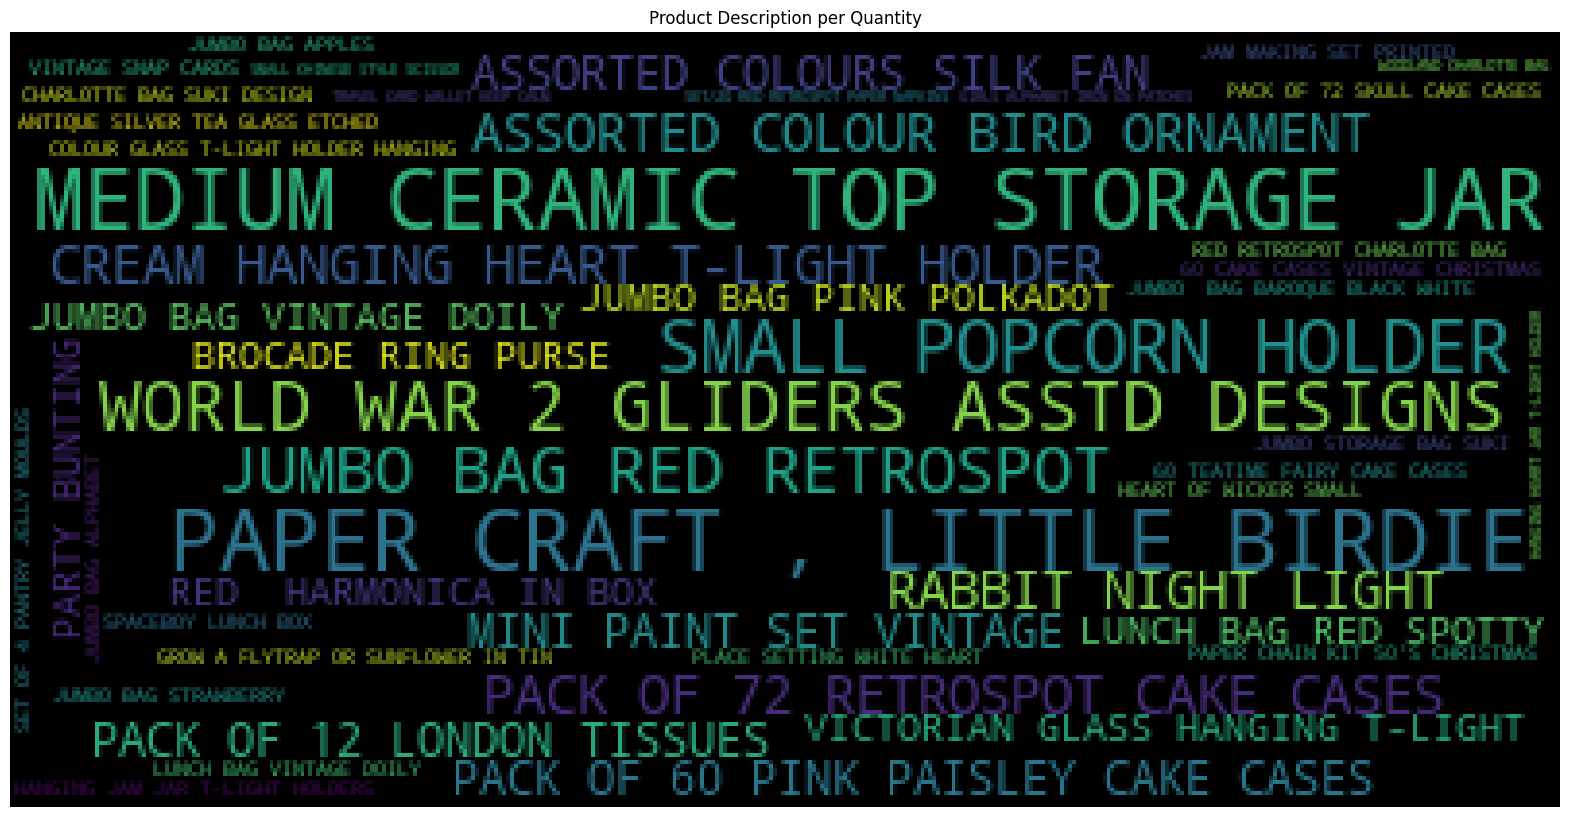

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

temp_df = pd.DataFrame(df.groupby('Description')['Quantity'].sum()).reset_index()
title = "Product Description per Quantity"
wordcloud_of_Description(temp_df, title)

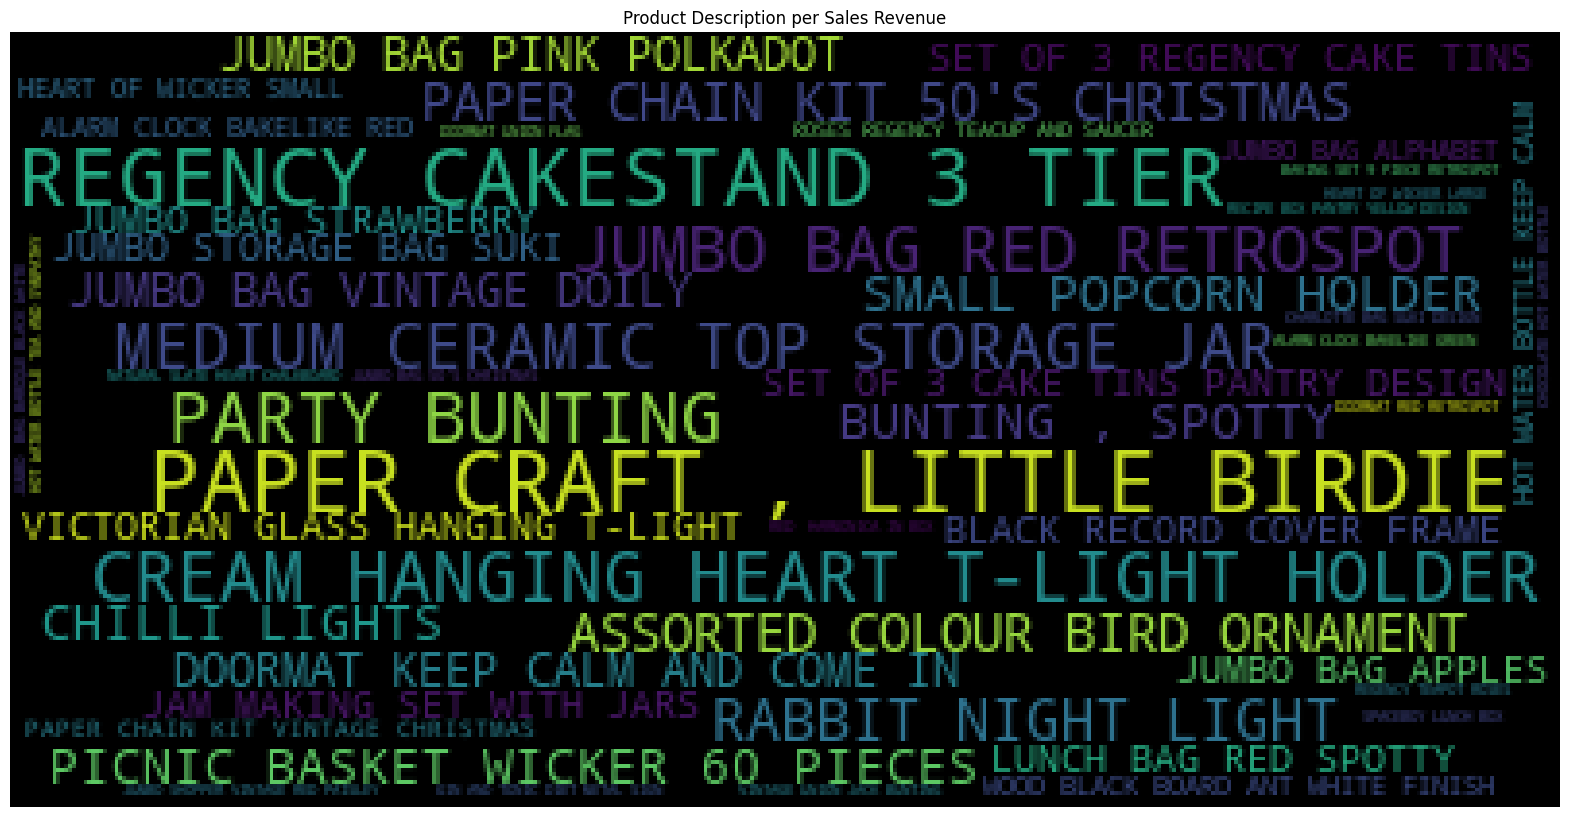

In [23]:
temp_df = pd.DataFrame(df.groupby('Description')['Sales Revenue'].sum()).reset_index()
title = "Product Description per Sales Revenue"
wordcloud_of_Description(temp_df, title)

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

temp_df = group_Quantity_and_SalesRevenue(df,'Month')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                  )

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Monthly Sales Revanue and Quantity")
pio.show(fig, height=700, width=1200)

In [26]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity per Month", "Sales Revenue per Month")
                    )
fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Month'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Month'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Monthly Sales Revanue and Quantity")

pio.show(fig, height=700, width=1200)
#fig.show( height=700, width=1000)

In [27]:
temp_df = group_Quantity_and_SalesRevenue(df,'Week of the Year')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Weekly Sales Revanue and Quantity")
pio.show(fig, height=700, width=1200)

In [28]:
temp_df = group_Quantity_and_SalesRevenue(df,'Day of Week')
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Greys'), showlegend=False, title_text="Day of the Week Sales Revanue and Quantity")
pio.show(fig, height=700, width=1200)

In [29]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Day of Week'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Day of Week'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Day of the Week Sales Revanue and Quantity")

pio.show(fig, height=700, width=1200)

In [30]:
temp_df = group_Quantity_and_SalesRevenue(df,'Time of Day')
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Time of Day'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Time of Day'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(title_text="Percentage pie charts for Time of Day Sales Revanue and Quantity")


pio.show(fig, height=700, width=1200)

In [31]:
#we can also look at the volume of Invoice Numbers hourly data 
Hourly_Sales = (df.groupby('Hour').sum()["Quantity"]).reset_index()
fig = px.bar(Hourly_Sales, x='Hour', y='Quantity', title='Hourly Volume of quantity sold')
pio.show(fig, height=700, width=1000)

C:\Users\USER\AppData\Local\Temp\ipykernel_11860\464431055.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [32]:
#we can also look at the volume quantity sold hourly data 
Hourly_Sales = (df.groupby('Hour').count()["InvoiceNo"]).reset_index()
fig = px.bar(Hourly_Sales, x='Hour', y='InvoiceNo', title='Hourly sale using the Invoice Numbers')
pio.show(fig, height=700, width=1000)

In [33]:
data = df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number')
pio.show(fig, height=700, width=1000)

In [35]:
temp_df = df[df["CustomerID"] != "Guest Customer"]
data = temp_df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number without the Guest Customer')
pio.show(fig, height=700, width=1000)

In [36]:
from IPython.display import display, HTML

temp_df = group_Quantity_and_SalesRevenue(df, 'Description')
Quantity_tempA = temp_df.sort_values(ascending=False, by = "Quantity").head(10).reset_index(drop=True)
Quantity_tempB = temp_df.sort_values(ascending=False, by = "Quantity").tail(10).reset_index(drop=True)

Quantity_tempA.drop('Sales Revenue', axis=1, inplace=True)
Quantity_tempB.drop('Sales Revenue', axis=1, inplace=True)
display_side_by_side([Quantity_tempA, Quantity_tempB], ['Top 10 Description by Quantity\n', 'Bottom 10 Description by Quantity\n'])

,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,78033
2,SMALL POPCORN HOLDER,54158
3,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49660
4,JUMBO BAG RED RETROSPOT,46220
5,ASSORTED COLOUR BIRD ORNAMENT,33977
6,CREAM HANGING HEART T-LIGHT HOLDER,33889
7,PACK OF 72 RETROSPOT CAKE CASES,32253
8,RABBIT NIGHT LIGHT,30726
9,MINI PAINT SET VINTAGE,23923


In [37]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Quantity_tempA['Description'], y=Quantity_tempA['Quantity'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Quantity_tempB['Description'], y=Quantity_tempB['Quantity'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Volume Quantity")
pio.show(fig, height=700, width=1200)

In [38]:
Sales_Revenue_tempA = temp_df.sort_values(ascending=False, by = "Sales Revenue").head(10).reset_index(drop=True)
Sales_Revenue_tempB = temp_df.sort_values(ascending=False, by = "Sales Revenue").tail(10).reset_index(drop=True)

Sales_Revenue_tempA.drop('Quantity', axis=1, inplace=True)
Sales_Revenue_tempB.drop('Quantity', axis=1, inplace=True)
display_side_by_side([Sales_Revenue_tempA, Sales_Revenue_tempB], ['Top 10 Description by Sales Revenue\n', 'Bottom 10 Description by Sales Revenue\n'])

,Description,Sales Revenue
0,"PAPER CRAFT , LITTLE BIRDIE",168469.600000
1,REGENCY CAKESTAND 3 TIER,146436.280000
2,PARTY BUNTING,98237.490000
3,CREAM HANGING HEART T-LIGHT HOLDER,94027.390000
4,JUMBO BAG RED RETROSPOT,90140.660000
5,MEDIUM CERAMIC TOP STORAGE JAR,81700.920000
6,RABBIT NIGHT LIGHT,66842.990000
7,PAPER CHAIN KIT 50'S CHRISTMAS,55667.490000
8,ASSORTED COLOUR BIRD ORNAMENT,54918.090000
9,PICNIC BASKET WICKER 60 PIECES,50287.910000


In [39]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Sales_Revenue_tempA['Description'], y=Sales_Revenue_tempA['Sales Revenue'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Sales_Revenue_tempB['Description'], y=Sales_Revenue_tempB['Sales Revenue'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Sales Revenue")
pio.show(fig, height=700, width=1200)

In [40]:
country_list = list(dict(df['Country'].value_counts()).keys())
def choose_country(country = "all", data = df):
  """
  This fuction takes in a country name and filters the data frame for just country
  if the there is no country inputed the fuction return the un filtered dataframe
  """
  if country == "all":
    return data
  else:
    temp_df = data[data["Country"] == country]
    temp_df.reset_index(drop= True, inplace= True)

    return temp_df

In [41]:
MBA_df = choose_country(country="United Kingdom")
MBA_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomeID,Date,Month,Week of the Year,Day of Week,Time,Hour,Time of Day,Sales Revenue
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,19.5
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,13313.0,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,12.5


In [42]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [43]:
#we are going to rearrage the dataframe having the 'InvoiceNo' column the index, so that each row contains all the items purchased under the same invoice
basket = (MBA_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))


In [44]:
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
def encoder(x):
  if(x <= 0):
    return 0
  if(x >= 1):
    return 1
  
#now we encode
basket = basket.applymap(encoder)
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
#we will filter out transactions that have less than 2 items 
basket = basket[ (basket > 0).sum(axis=1) >= 2]
basket.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)
frequent_itemsets.head()

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,support,itemsets
0,0.034107,(3 DRAWER ANTIQUE WHITE WOOD CABINET)
1,0.051718,(6 RIBBONS RUSTIC CHARM)
2,0.033252,(60 CAKE CASES VINTAGE CHRISTMAS)
3,0.045541,(60 TEATIME FAIRY CAKE CASES)
4,0.033647,(72 SWEETHEART FAIRY CAKE CASES)


In [49]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.051127,0.055924,0.032989,0.645244,11.537816,0.030130,2.661199,0.962540
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.055924,0.051127,0.032989,0.589894,11.537816,0.030130,2.313728,0.967431
2,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.058947,0.049221,0.035552,0.603122,12.253271,0.032651,2.395642,0.975917
3,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.049221,0.058947,0.035552,0.722296,12.253271,0.032651,3.388695,0.965934
4,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.057239,0.045673,0.037655,0.657865,14.403920,0.035041,2.789326,0.987073


In [50]:
# Sort values based on lift
rules = rules.sort_values("lift",ascending=False).reset_index(drop= True)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.045673,0.042913,0.032201,0.705036,16.429605,0.030241,3.244760,0.984080
1,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.042913,0.045673,0.032201,0.750383,16.429605,0.030241,3.823164,0.981242
2,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.057239,0.035684,0.032201,0.562572,15.765478,0.030158,2.204513,0.993433
3,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.035684,0.057239,0.032201,0.902394,15.765478,0.030158,9.658857,0.971227
4,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.037655,0.058356,0.032201,0.855148,14.654045,0.030003,6.500749,0.968218


In [51]:
rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.072857,0.072857,0.034332,0.512566,7.714453,0.029083,2.227341,0.913404
std,0.023260,0.023260,0.004285,0.151407,3.607937,0.004048,1.297531,0.048457
min,0.035684,0.035684,0.030032,0.253179,3.164024,0.022248,1.257651,0.748696
25%,0.057239,0.057239,0.031774,0.419975,5.519586,0.026322,1.608536,0.895815
50%,0.068443,0.068443,0.032332,0.476253,6.256990,0.027911,1.762935,0.910442
75%,0.075705,0.075705,0.035684,0.610747,8.468103,0.030885,2.381215,0.943242
max,0.118880,0.118880,0.049090,0.902394,16.429605,0.040465,9.658857,0.993433


In [52]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         70 non-null     object 
 1   consequents         70 non-null     object 
 2   antecedent support  70 non-null     float64
 3   consequent support  70 non-null     float64
 4   support             70 non-null     float64
 5   confidence          70 non-null     float64
 6   lift                70 non-null     float64
 7   leverage            70 non-null     float64
 8   conviction          70 non-null     float64
 9   zhangs_metric       70 non-null     float64
dtypes: float64(8), object(2)
memory usage: 5.6+ KB


In [53]:
temp_df = rules.head(50).copy()
temp_df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.045673,0.042913,0.032201,0.705036,16.429605,0.030241,3.244760,0.984080
1,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.042913,0.045673,0.032201,0.750383,16.429605,0.030241,3.823164,0.981242
2,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.057239,0.035684,0.032201,0.562572,15.765478,0.030158,2.204513,0.993433
3,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.035684,0.057239,0.032201,0.902394,15.765478,0.030158,9.658857,0.971227
4,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.037655,0.058356,0.032201,0.855148,14.654045,0.030003,6.500749,0.968218


In [54]:
RFM_df = choose_country(country="United Kingdom") 

In [55]:
import datetime as dt
#the first thing that we are going to need is the reference date 
#in this case the day after the last recorded date in the dataset plus a day
ref_date = RFM_df['InvoiceDate'].max() + dt.timedelta(days=1)
ref_date 

Timestamp('2011-12-10 12:49:00')

In [56]:
#for RFM we are going to remove the 'Guest Customer' the customers without Customer ID
df_temp = RFM_df[RFM_df['CustomerID'] != "Guest Customer"]

In [57]:
RFM_df = df_temp.groupby('CustomerID').agg({'InvoiceDate': lambda x: (ref_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'Sales Revenue': lambda x: x.sum()})

RFM_df.columns = ['Recency', 'Frequency', 'Monetary']
RFM_df["R"] = pd.qcut(RFM_df['Recency'].rank(method="first"), 4, labels=[4, 3, 2, 1])
RFM_df["F"] = pd.qcut(RFM_df['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df["M"] = pd.qcut(RFM_df['Monetary'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df['RFM_Score'] = (RFM_df['R'].astype(int)+RFM_df['F'].astype(int)+RFM_df['M'].astype(int))

RFM_df.reset_index(inplace=True)

RFM_df.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,6
1,12747.0,2,9,3489.74,4,4,4,12
2,12748.0,1,171,27508.01,4,4,4,12
3,12749.0,4,5,4040.88,4,4,4,12
4,12820.0,3,4,942.34,4,3,3,10
5,12821.0,214,1,92.72,1,1,1,3
6,12822.0,71,2,948.88,2,2,3,7
7,12823.0,75,5,1759.50,2,4,4,10
8,12824.0,60,1,397.12,2,1,2,5
9,12826.0,3,6,1319.72,4,4,3,11


In [59]:
RFM_df[["RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("RFM_Score").agg(["mean", "count"])

Recency        Frequency            Monetary      
                 mean count       mean count          mean count
RFM_Score                                                       
3          239.799228   259   1.000000   259    156.555946   259
4          189.821670   443   1.076749   443    245.367878   443
5          121.600451   443   1.279910   443    343.871402   443
6           83.022371   447   1.554810   447    633.773266   447
7           74.116711   377   2.119363   377    648.077379   377
8           57.066852   359   2.743733   359   1099.946852   359
9           39.348168   382   3.424084   382   1193.592568   382
10          33.958944   341   5.020528   341   2318.608387   341
11          20.241791   335   7.292537   335   3038.544328   335
12           6.834515   423  17.087470   423  10739.138085   423

In [60]:
from sklearn.preprocessing import StandardScaler

#now we will use the standard scalr function from SKlean preprocessing and scale transform fit the data (without the Customer Id column)
scaler = StandardScaler()
RFM_df_log = RFM_df[['Recency','Frequency','Monetary','RFM_Score']]
RFM_df_scaled = scaler.fit_transform(RFM_df_log)
RFM_df_scaled = pd.DataFrame(RFM_df_scaled)
RFM_df_scaled.columns = ['Recency','Frequency','Monetary','RFM_Score']

RFM_df_scaled.head()

,Recency,Frequency,Monetary,RFM_Score
0,2.695188,-0.166182,3.419885,-0.531779
1,-0.920836,0.233684,0.062920,1.595896
2,-0.931997,8.330987,1.157020,1.595896
3,-0.898515,0.033751,0.088026,1.595896
4,-0.909676,-0.016232,-0.053122,0.886671


In [61]:
from sklearn.cluster import KMeans

the_scores = []
for i in range(2,11): #we will explore from 2 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10,max_iter=50,verbose=0)
    kmeans.fit(RFM_df_scaled)
    the_scores.append(kmeans.inertia_)

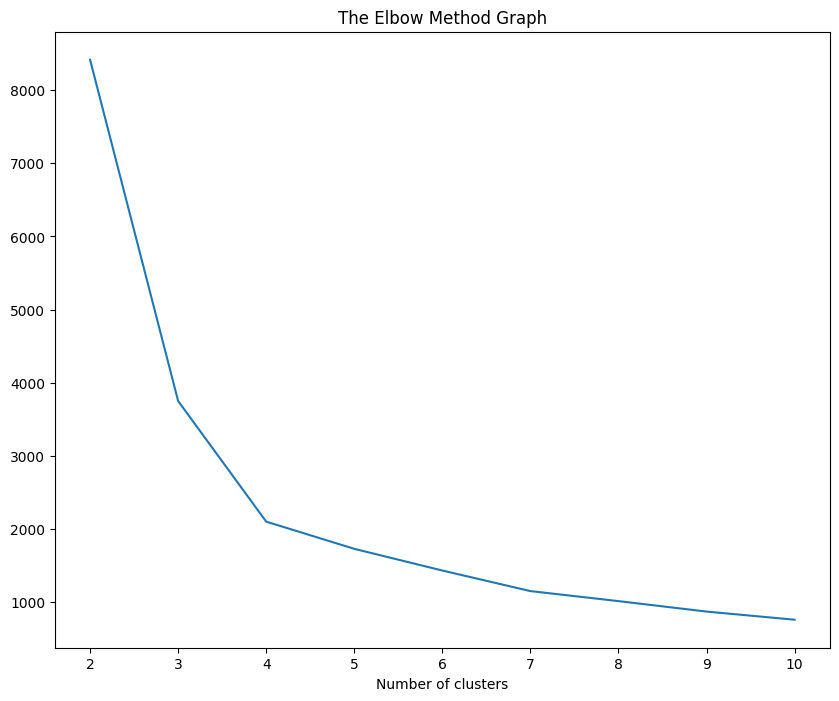

In [62]:
#lets plot the Elbow
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(range(2,11,1),the_scores)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.xticks(ticks=range(2,11))
plt.show()

In [63]:
from sklearn.metrics import silhouette_score

#calculating the silhouette_score from the sklearn metrics module function silhouette_score
for i in range(2,11):
   kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10,max_iter=50,verbose=0)
   kmeans.fit(RFM_df_scaled)
   silhouette = silhouette_score(RFM_df_scaled,kmeans.labels_)
   print("for {} clusters the silhouette_score is {}".format(i,silhouette))

for 2 clusters the silhouette_score is 0.9783542923053947
for 3 clusters the silhouette_score is 0.5151949147998822
for 4 clusters the silhouette_score is 0.49520856323814166
for 5 clusters the silhouette_score is 0.4295053469021964
for 6 clusters the silhouette_score is 0.421431267623974
for 7 clusters the silhouette_score is 0.4294623703227148
for 8 clusters the silhouette_score is 0.43427250016581304
for 9 clusters the silhouette_score is 0.3954035546649508
for 10 clusters the silhouette_score is 0.4093431140665703


In [64]:
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=10,max_iter=50,verbose=0)
kmeans.fit(RFM_df_scaled)

KMeans(max_iter=50, n_clusters=4, n_init=10)

In [65]:
RFM_df['Clusters'] = kmeans.labels_

RFM_df.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Clusters
0,12346.0,326,1,77183.60,1,1,4,6,2
1,12747.0,2,9,3489.74,4,4,4,12,3
2,12748.0,1,171,27508.01,4,4,4,12,3
3,12749.0,4,5,4040.88,4,4,4,12,3
4,12820.0,3,4,942.34,4,3,3,10,3


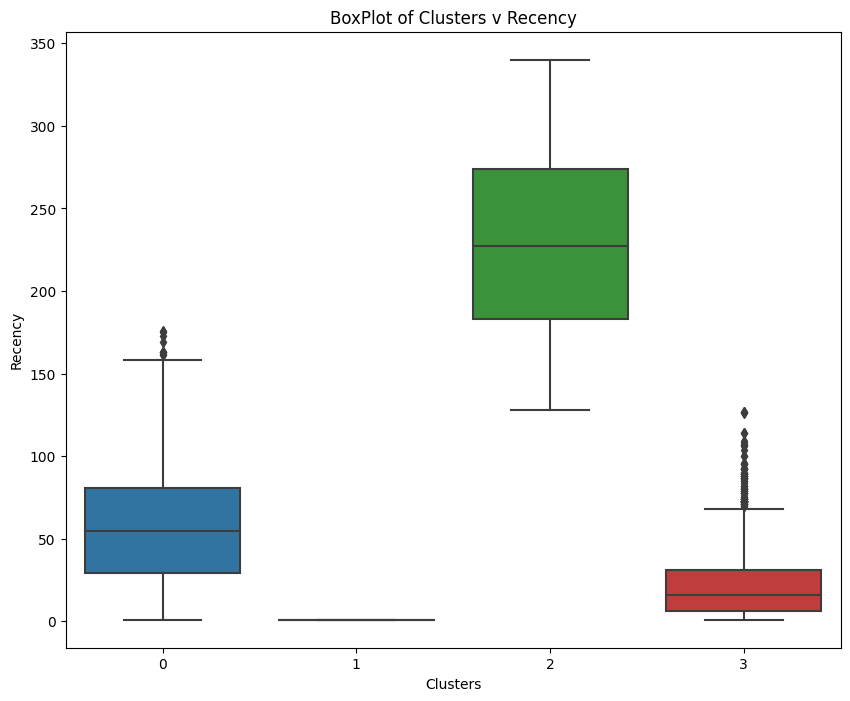

In [66]:
import seaborn as sns

sns.boxplot( x= 'Clusters',y= 'Recency' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Recency")
plt.show()

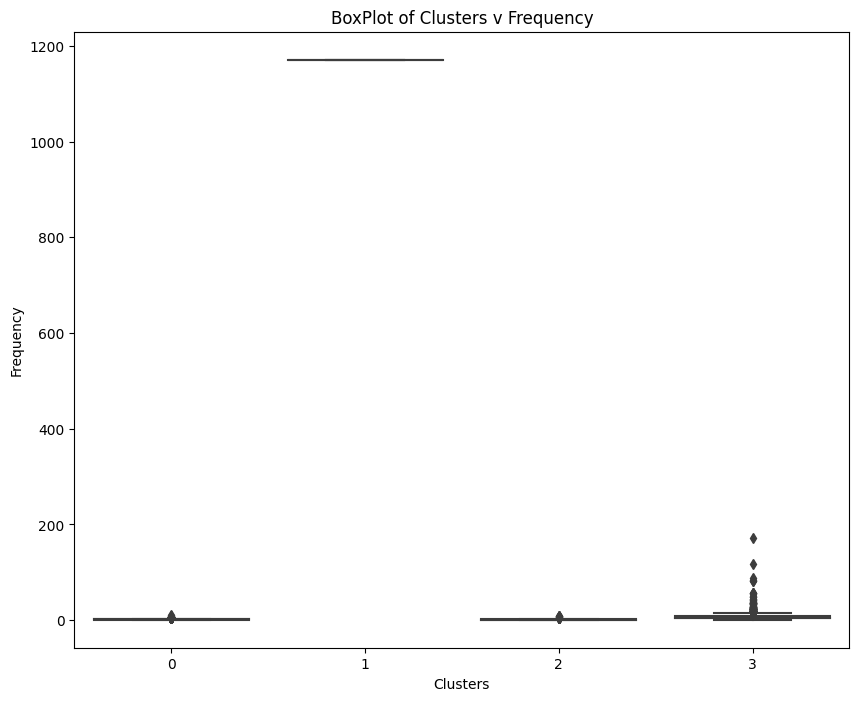

In [67]:
sns.boxplot( x= 'Clusters',y= 'Frequency' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Frequency")
plt.show()

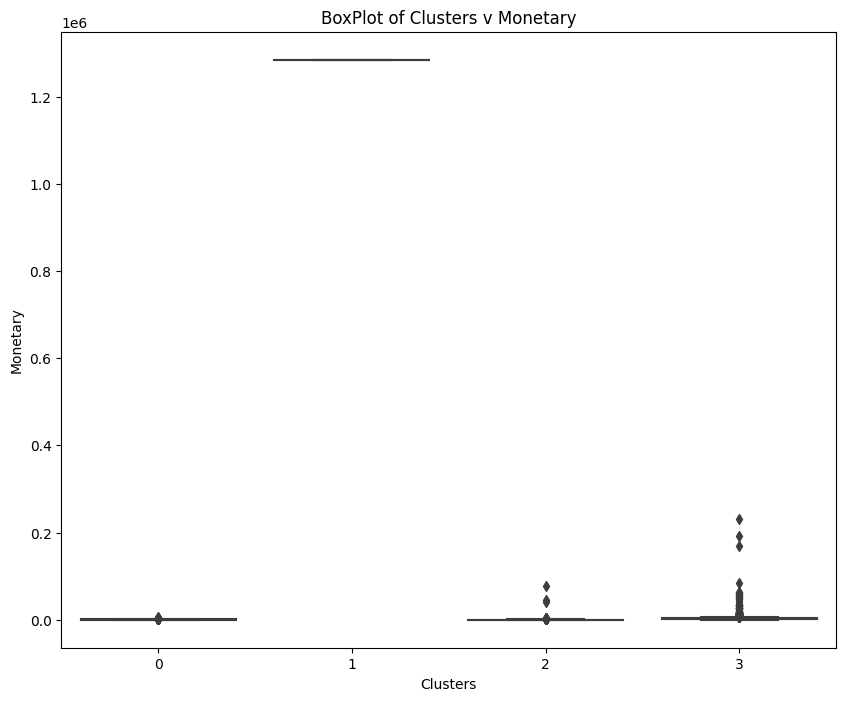

In [68]:
sns.boxplot( x= 'Clusters',y= 'Monetary' ,data=RFM_df)
plt.rcParams["figure.figsize"] = (10,8)
plt.title("BoxPlot of Clusters v Monetary")
plt.show()

In [69]:
temp_df = RFM_df[["Clusters","RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("Clusters").agg(["mean"])
temp_df.columns = ["RFM_Score mean", "Recency mean", "Frequency mean", "Monetary mean"]
temp_df

,RFM_Score mean,Recency mean,Frequency mean,Monetary mean
Clusters,,,,
0,6.395129,59.281461,1.817321,5.324039e+02
1,12.000000,1.000000,1171.000000,1.284416e+06
2,4.284414,229.723549,1.416382,5.652437e+02
3,10.569263,22.291523,7.836664,3.765053e+03


In [70]:
specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("RFM_Score", "Recency", "Frequency","Monetary"),
                    specs=specs
                    )

fig.add_trace(
    go.Pie(values = temp_df['RFM_Score mean'], labels = temp_df.index,
    name = 'RFM_Score'),
    1, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Recency mean'], labels = temp_df.index,
    name = 'Recency'),
    1, 2
)
fig.add_trace(
    go.Pie(values = temp_df['Frequency mean'], labels = temp_df.index,
    name = 'Frequency'),
    2, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Monetary mean'], labels = temp_df.index,
    name = 'Monetary'),
    2, 2
)
fig.update_layout(height=800, width=1200, title_text=" ")
fig.show()

In [72]:
from numpy.lib.arraysetops import unique

product_catalog = list(unique(MBA_df['Description']))

In [73]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.045673,0.042913,0.032201,0.705036,16.429605,0.030241,3.244760,0.984080
1,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.042913,0.045673,0.032201,0.750383,16.429605,0.030241,3.823164,0.981242
2,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.057239,0.035684,0.032201,0.562572,15.765478,0.030158,2.204513,0.993433
3,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.035684,0.057239,0.032201,0.902394,15.765478,0.030158,9.658857,0.971227
4,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.037655,0.058356,0.032201,0.855148,14.654045,0.030003,6.500749,0.968218


In [75]:
def remove_from_list(y, item_to_search):
  newlist = list()
  for i in y:
    if i not in item_to_search:
      newlist.append(i)
  return newlist

In [76]:
def search_list(item_to_search, list_to_search = rules['antecedents']):
  print(item_to_search)
  max_lift = 0
  item_to_recommend = ''
  for i, item in enumerate(list_to_search):
    if set(list(item_to_search)).issubset(set(list(item))):
      if rules['lift'][i] > max_lift:
        max_lift = rules['lift'][i]
        y = list(rules['antecedents'][i])
        x = remove_from_list(y, item_to_search)
        item_to_recommend = list(rules['consequents'][i]) + x
  if item_to_recommend == '':
    print("There are no Product recommendations")
  else:
    return print(f"People who bought this also bought: {item_to_recommend}")

In [77]:
for i in range(len(product_catalog)):
  search_list([product_catalog[i]])

['10 COLOUR SPACEBOY PEN']
There are no Product recommendations
['12 COLOURED PARTY BALLOONS']
There are no Product recommendations
['12 DAISY PEGS IN WOOD BOX']
There are no Product recommendations
['12 EGG HOUSE PAINTED WOOD']
There are no Product recommendations
['12 HANGING EGGS HAND PAINTED']
There are no Product recommendations
['12 IVORY ROSE PEG PLACE SETTINGS']
There are no Product recommendations
['12 MESSAGE CARDS WITH ENVELOPES']
There are no Product recommendations
['12 PENCIL SMALL TUBE WOODLAND']
There are no Product recommendations
['12 PENCILS SMALL TUBE RED RETROSPOT']
There are no Product recommendations
['12 PENCILS SMALL TUBE SKULL']
There are no Product recommendations
['12 PENCILS TALL TUBE POSY']
There are no Product recommendations
['12 PENCILS TALL TUBE RED RETROSPOT']
There are no Product recommendations
['12 PENCILS TALL TUBE SKULLS']
There are no Product recommendations
['12 PENCILS TALL TUBE WOODLAND']
There are no Product recommendations
['12 PINK HEN+CHI